### Dataset
Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. Zalando intends Fashion-MNIST to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits.

### Content
* Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total.

* Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255.

* The training and test data sets have 785 columns.

* The first column consists of the class labels (see above), and represents the article of clothing.

* The rest of 784 columns (1-785) contain the pixel-values of the associated image.

### Import Libraries

In [92]:
# import necessary libraries
import numpy as np # linear algebra
import seaborn as sns # to visualize statistical data
import matplotlib.pyplot as plt # for MATLAB-like way of plotting.
import time
import pandas as pd


# import keras libraries
from tensorflow.python import keras
from keras.models import load_model # to save the model
from sklearn.metrics import confusion_matrix # to compute confusion matrix to evaluate the accuracy of a classification
from keras.utils.np_utils import to_categorical # to encode categorical integer features as a one-hot numeric array.
from keras.datasets import fashion_mnist # to load the fashion mnist dataset
from sklearn.model_selection import train_test_split # cross validation
from keras.preprocessing.image import ImageDataGenerator # for Image Augmentation
from keras.regularizers import l2,l1 # regularization


# libraries for construction of CNN model
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.optimizers import Adam
#from keras.callbacks import ReduceLROnPlateau


import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
# import warnings
import warnings
# filter warnings
warnings.filterwarnings('ignore')

### Arguments

In [104]:
# Output directories
MODEL_OUTPUT_DIRECTORY = 'saved_models/'
MODEL_HISTORY_OUTPUT_DIRECTORY = 'saved_model_histories/'

# data arguments
ROWS = 28
COLUMNS = 28
CLASS = 10

TEST_SIZE = 0.2
RANDOM_STATE = 2018

# Model hyperparameters
BATCH_SIZE = 128
NUMBER_OF_EPOCHS = 50
SHIFT = 0.3

### Load Dataset

There are 10 different classes of images, as following:

0	T-shirt/top <br>
1	Trouser <br>
2	Pullover <br>
3	Dress <br>
4	Coat <br>
5	Sandal <br>
6	Shirt <br>
7	Sneaker <br>
8	Bag <br>
9	Ankle boot <br>

Image dimmensions are 28x28.

The train set and test set are given in two separate datasets.

In [41]:
# load dataset
(trainX, trainY), (testX, testY) = fashion_mnist.load_data()

# summarize loaded dataset
print("TrainX: "+str(trainX.shape))
print("TrainY: "+str(trainY.shape))
print("TestX: "+str(testX.shape))
print("TestY: "+str(testY.shape))

TrainX: (60000, 28, 28)
TrainY: (60000,)
TestX: (10000, 28, 28)
TestY: (10000,)


### Class Distribution
Let's see how many number of images are in each class. We start with the train set.

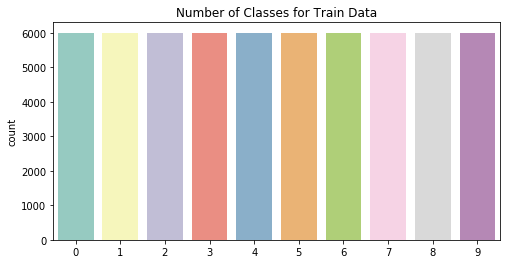

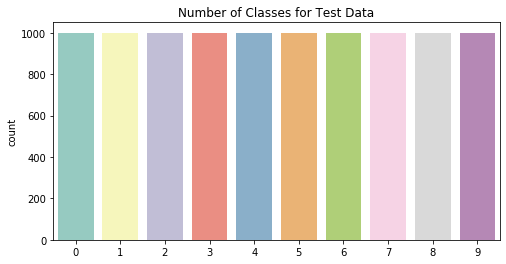

In [42]:
plt.figure(figsize=(8, 4))
sns.countplot(trainY, palette="Set3")
plt.title("Number of Classes for Train Data")
plt.show()
plt.figure(figsize=(8, 4))
sns.countplot(testY, palette="Set3")
plt.title("Number of Classes for Test Data")
plt.show()

Train and test datas are balanced
#### View some random images

In [43]:
# Create a dataframe from train data (x and y)
# merge label and pixel array,create a dataframe, of size (60000, 785). 
# Dataframe: 60000 rows. Each row holds label, pixel1, pixel2, ..., pixel784.
def create_dataframe(x_data,y_data):
    y_data_list = y_data.tolist()
    y_data_adjusted = np.array([y_data_list]) # needed step for contatenation
    num_images = x_data.shape[0] 
    x_data_array  = x_data.reshape(num_images, ROWS*COLUMNS)
    data_array = np.concatenate((y_data_adjusted.T, x_data_array), axis=1)
    pixel_idx = range(1,ROWS*COLUMNS+1) 
    pixel_names = ['pixel' + str(i) for i in pixel_idx]
    columns = ['label'] + pixel_names
    data_df = pd.DataFrame(data_array, columns = columns) 
    return data_df

train_data_df = create_dataframe(trainX, trainY)
test_data_df = create_dataframe(testX, testY)


Add labels to the train set images, with the corresponding fashion item category.

In [44]:
labels = {0 : "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat",
          5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle Boot"}

def sample_images_data(data):
    # An empty list to collect some samples
    sample_images = []
    sample_labels = []

    # Iterate over the keys of the labels dictionary defined in the above cell
    for k in labels.keys():
        # Get four samples for each category
        samples = data[data["label"] == k].head(4)
        # Append the samples to the samples list
        for j, s in enumerate(samples.values):
            # First column contain labels, hence index should start from 1
            img = np.array(samples.iloc[j, 1:]).reshape(ROWS,COLUMNS)
            sample_images.append(img)
            sample_labels.append(samples.iloc[j, 0])

    print("Total number of sample images to plot: ", len(sample_images))
    return sample_images, sample_labels

train_sample_images, train_sample_labels = sample_images_data(train_data_df)

Total number of sample images to plot:  40


Let's now plot the images.
The labels are shown above each image.

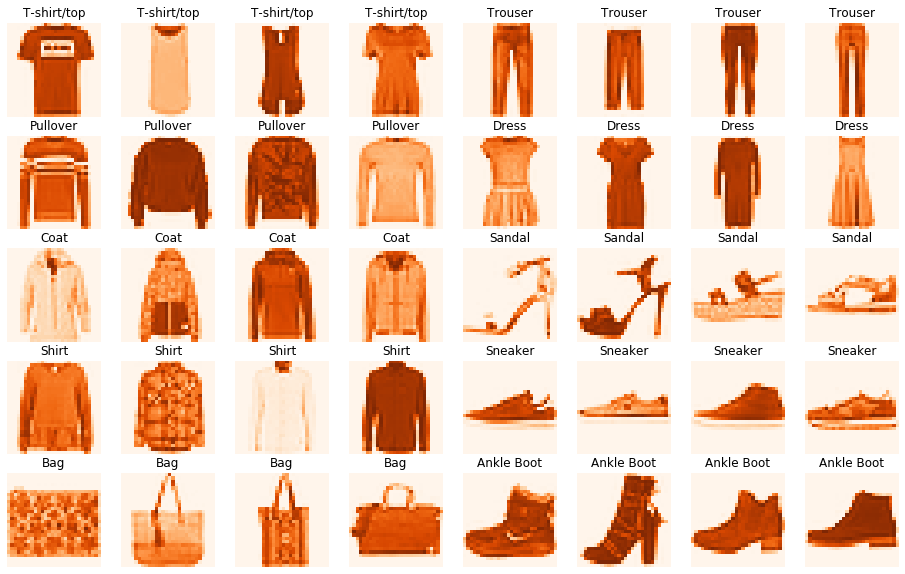

In [79]:
def plot_sample_images(data_sample_images,data_sample_labels,cmap="Blues"):
    # Plot the sample images now
    f, ax = plt.subplots(5,8, figsize=(16,10))

    for i, img in enumerate(data_sample_images):
        ax[i//8, i%8].imshow(img, cmap=cmap)
        ax[i//8, i%8].axis('off')
        ax[i//8, i%8].set_title(labels[data_sample_labels[i]])
    plt.show()    
    
plot_sample_images(train_sample_images,train_sample_labels, "Oranges")

## Model

### Data preprocessing

First we will do a data preprocessing to prepare for the model.
We reshape the columns from (784) to (28,28,1). We also save label (target) feature as a separate vector.

#### Encoding
We also know that there are 10 classes and that classes are represented as unique integers:

0	T-shirt/top <br>
1	Trouser <br>
2	Pullover <br>
3	Dress <br>
4	Coat <br>
5	Sandal <br>
6	Shirt <br>
7	Sneaker <br>
8	Bag <br>
9	Ankle boot <br>

We can, therefore, use a one hot encoding for the class element of each sample, transforming the integer into a 10 element binary vector with a 1 for the index of the class value. We can achieve this with the to_categorical() utility function.

In [46]:
# one hot encode target values
trainY = to_categorical(trainY)
testY = to_categorical(testY)

print("trainY: "+str(trainY.shape))
print("testY: "+str(testY.shape))

trainY: (60000, 10)
testY: (10000, 10)


#### Normalization
We know that the pixel values for each image in the dataset are unsigned integers in the range 0 and 255. (black and white range)

So, normalize the pixel values of grayscale images, e.g. rescale them to the range [0,1].

In [47]:
# scale data to the range of [0, 1]
trainX = trainX.astype("float32") / 255.0
testX = testX.astype("float32") / 255.0

#### Train, Test, Validation
The dataset already defined as train and test.

In order to calculate the performance of a model for a given training, we need to split the training set into a train and validation dataset. Performance on the train and validation dataset over each run can then be plotted to provide learning curves and insight into how well a model is learning the problem.

In [48]:
# reshape the data arrays to have a single color channel.
trainX = trainX.reshape((trainX.shape[0], ROWS, COLUMNS, 1))
testX = testX.reshape((testX.shape[0], ROWS, COLUMNS, 1))

X_train, X_val, y_train, y_val = train_test_split(trainX, trainY, test_size=TEST_SIZE, random_state=RANDOM_STATE)

print("trainX: "+str(X_train.shape))
print("validationX: "+str(X_val.shape))
print("trainY: "+str(y_train.shape))
print("validationY: "+str(y_val.shape))

trainX: (48000, 28, 28, 1)
validationX: (12000, 28, 28, 1)
trainY: (48000, 10)
validationY: (12000, 10)


### Train the Model

#### Build the model

I will use a Sequential model.

The Sequential model is a linear stack of layers. It can be first initialized and then we add layers using add method or we can add all layers at init stage. The layers added are as follows:

I tried to train different models with different specifications. I mostly inspired by VGGNet. Firstly, I will give a brief explanation for the VGGNet.

#### VGGNet

VGGNet consists of 16 convolutional layers and is very appealing because of its very uniform architecture. Similar to AlexNet, only 3x3 convolutions, but lots of filters. It is currently the most preferred choice in the community for extracting features from images. However, VGGNet consists of 138 million parameters, which can be a bit challenging to handle. <br>
<br>
<img src="https://miro.medium.com/max/1575/0*V1muWIDnPVwZUuEv.png" width="75%">

##### Layers
Below we define our CNNmodel with the Sequential() function before defining the specific layers we will apply to our convolutional neural network.

##### Conv + Maxpool
The Convolution layer is the main process for the CNN. In this operation, there is a filter detecting edges or specific shapes, beginning in the top left of the image. The filter is multiplied with some value across the same indices, after which the results are summed and put into an output matrix. The filter then 'strides' right and repeats the process again and again. Following these operations we apply a ReLU function. The maxpooling in this later reduces the parameters needed for the computing process. Maxpooling prevents overfitting.

##### Dropout
Dropout is a regularization technique that aids in reducing overfitting by dropping out visible or hidden nodes in the neural network.

##### Flattening
Basically after applying our laters we need to flatten the matrix into a one dimensional array for use with the rest of our CNN. Does not affect the batch size. It is used without parameters.

##### Fully Connecting
This layer takes data from the 1D array we created with our flattening layer and begins the learning process.

#### Dense. 

This layer is a regular fully-connected NN layer.

##### Then we compile the model, specifying as well the following parameters:

* loss
* optimizer
* metrics

-------------------------------------------------------------------------------------------------------------------

### Model 1

In [49]:
# Model
cnn1 = Sequential()
# Add convolution 2D
cnn1.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 kernel_initializer='he_normal',
                 input_shape=(ROWS, COLUMNS, 1)))
cnn1.add(MaxPooling2D((2, 2)))
cnn1.add(Conv2D(64, 
                 kernel_size=(3, 3), 
                 activation='relu'))
cnn1.add(MaxPooling2D(pool_size=(2, 2)))
cnn1.add(Conv2D(128, (3, 3), activation='relu'))
cnn1.add(Flatten())
cnn1.add(Dense(128, activation='relu'))
cnn1.add(Dense(CLASS, activation='softmax'))


cnn1.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

cnn1.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 3, 3, 128)         73856     
_________________________________________________________________
flatten_3 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)              

#### Run the model
We run the model with the training set. We are also using the validation set (a subset from the orginal training set) for validation.

train_model = model.fit(X_train, y_train,
                  batch_size=BATCH_SIZE,
                  epochs=NO_EPOCHS,
                  verbose=1,
                  validation_data=(X_val, y_val))

In [50]:
start_time = time.time()
train_model = cnn1.fit(X_train, y_train,
                  batch_size=BATCH_SIZE,
                  epochs=NUMBER_OF_EPOCHS,
                  verbose=1,
                  validation_data=(X_val, y_val))
end_time = time.time()
duration = end_time - start_time

Train on 48000 samples, validate on 12000 samples
Epoch 1/50
48000/48000 [==============================] - 28s 586us/step - loss: 0.5282 - accuracy: 0.8092 - val_loss: 0.3573 - val_accuracy: 0.8748
Epoch 2/50
48000/48000 [==============================] - 30s 630us/step - loss: 0.3345 - accuracy: 0.8785 - val_loss: 0.3026 - val_accuracy: 0.8935
Epoch 3/50
48000/48000 [==============================] - 30s 632us/step - loss: 0.2837 - accuracy: 0.8966 - val_loss: 0.2800 - val_accuracy: 0.9016
Epoch 4/50
48000/48000 [==============================] - 30s 631us/step - loss: 0.2496 - accuracy: 0.9078 - val_loss: 0.2690 - val_accuracy: 0.9028
Epoch 5/50
48000/48000 [==============================] - 33s 693us/step - loss: 0.2242 - accuracy: 0.9181 - val_loss: 0.2715 - val_accuracy: 0.9053
Epoch 6/50
48000/48000 [==============================] - 33s 678us/step - loss: 0.2007 - accuracy: 0.9256 - val_loss: 0.2606 - val_accuracy: 0.9093
Epoch 7/50
48000/48000 [==============================] 

#### Test prediction accuracy
We calculate the test loss and accuracy.

In [65]:
score = cnn1.evaluate(testX, testY, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print('Duration: ',duration)

10000/10000 [==============================] - 2s 172us/step
Test loss: 0.7261430284757167
Test accuracy: 0.9100000262260437
Duration:  1674.1493618488312


Test accuracy is  ~0.91.

We evaluated the model accuracy based on the predicted values for the test set. Let's check the validation value during training.

### Plot Functions

In [59]:
def create_trace(x,y,ylabel,color):
        trace = go.Scatter(
            x = x,y = y,
            name=ylabel,
            marker=dict(color=color),
            mode = "markers+lines",
            text=x
        )
        return trace
    
def plot_accuracy_and_loss(train_model):
    hist = train_model.history
    acc = hist['accuracy']
    val_acc = hist['val_accuracy']
    loss = hist['loss']
    val_loss = hist['val_loss']
    epochs = list(range(1,len(acc)+1))
    
    trace_ta = create_trace(epochs,acc,"Training accuracy", "Green")
    trace_va = create_trace(epochs,val_acc,"Validation accuracy", "Red")
    trace_tl = create_trace(epochs,loss,"Training loss", "Blue")
    trace_vl = create_trace(epochs,val_loss,"Validation loss", "Orange")
   
    fig = tools.make_subplots(rows=1,cols=2, subplot_titles=('Training and validation accuracy',
                                                             'Training and validation loss'))
    fig.append_trace(trace_ta,1,1)
    fig.append_trace(trace_va,1,1)
    fig.append_trace(trace_tl,1,2)
    fig.append_trace(trace_vl,1,2)
    fig['layout']['xaxis'].update(title = 'Epoch')
    fig['layout']['xaxis2'].update(title = 'Epoch')
    fig['layout']['yaxis'].update(title = 'Accuracy', range=[0,1])
    fig['layout']['yaxis2'].update(title = 'Loss', range=[0,1])

    
    iplot(fig, filename='accuracy-loss')

plot_accuracy_and_loss(train_model)

The validation accuracy does not improve after few epochs and the validation loss is increasing after few epochs. This confirms our assumption that the model is overfitted. We will try to improve the model by adding Dropout layers.

### Add Dropout layers to the model

We add several Dropout layers to the model, to help avoiding overfitting.
Dropout is helping avoid overfitting.

In [66]:
# Model
cnn2 = Sequential()
# Add convolution 2D
cnn2.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 kernel_initializer='he_normal',
                 input_shape=(ROWS, COLUMNS, 1)))
cnn2.add(MaxPooling2D((2, 2)))
# Add dropouts to the model
cnn2.add(Dropout(0.25))
cnn2.add(Conv2D(64, 
                 kernel_size=(3, 3), 
                 activation='relu'))
cnn2.add(MaxPooling2D(pool_size=(2, 2)))
# Add dropouts to the model
cnn2.add(Dropout(0.25))
cnn2.add(Conv2D(128, (3, 3), activation='relu'))
# Add dropouts to the model
cnn2.add(Dropout(0.4))
cnn2.add(Flatten())
cnn2.add(Dense(128, activation='relu'))
# Add dropouts to the model
cnn2.add(Dropout(0.3))
cnn2.add(Dense(CLASS, activation='softmax'))


cnn2.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

cnn2.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 3, 3, 128)        

In [67]:
start_time = time.time()
train_model2 = cnn2.fit(X_train, y_train,
                  batch_size=BATCH_SIZE,
                  epochs=NUMBER_OF_EPOCHS,
                  verbose=1,
                  validation_data=(X_val, y_val))
end_time = time.time()
duration = end_time - start_time

Train on 48000 samples, validate on 12000 samples
Epoch 1/50
48000/48000 [==============================] - 34s 704us/step - loss: 0.7984 - accuracy: 0.7006 - val_loss: 0.5018 - val_accuracy: 0.8208
Epoch 2/50
48000/48000 [==============================] - 36s 751us/step - loss: 0.5015 - accuracy: 0.8126 - val_loss: 0.4022 - val_accuracy: 0.8508
Epoch 3/50
48000/48000 [==============================] - 36s 749us/step - loss: 0.4289 - accuracy: 0.8420 - val_loss: 0.3514 - val_accuracy: 0.8722
Epoch 4/50
48000/48000 [==============================] - 45s 933us/step - loss: 0.3859 - accuracy: 0.8593 - val_loss: 0.3161 - val_accuracy: 0.8854
Epoch 5/50
48000/48000 [==============================] - 42s 868us/step - loss: 0.3588 - accuracy: 0.8693 - val_loss: 0.2907 - val_accuracy: 0.8947
Epoch 6/50
48000/48000 [==============================] - 40s 823us/step - loss: 0.3397 - accuracy: 0.8766 - val_loss: 0.2768 - val_accuracy: 0.8989
Epoch 7/50
48000/48000 [==============================] 

#### Test prediction accuracy
Re-calculate the test loss and accuracy with the new model.

In [68]:
score = cnn2.evaluate(testX, testY, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print('Duration: ',duration)

10000/10000 [==============================] - 2s 166us/step
Test loss: 0.22508072773218155
Test accuracy: 0.914900004863739
Duration:  1882.3961148262024


In [69]:
plot_accuracy_and_loss(train_model2)

After adding the Dropout layers, the validation accuracy and validation loss are much better.

### Plot Confusion Matrix
Confusion matrix will allow us to visualize our algorithms performance, plotting the correct answers against the answers our model has estimated. With it, we will be able to see which 'classes' of clothing items are least accurately predicted by our model. (We could then pass additional items of that class in order to strengthen our machines predictive capabilities)

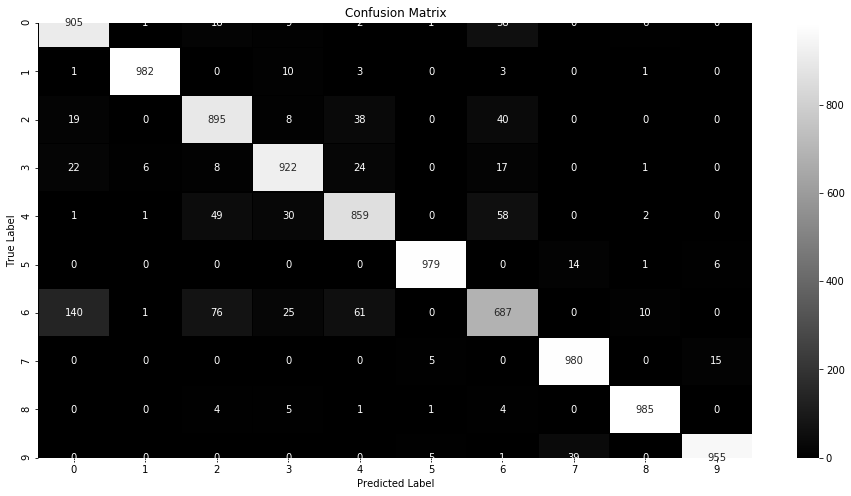

Class: 0
Number of Wrong Prediction: 95 out of 1000
Class: 1
Number of Wrong Prediction: 18 out of 1000
Class: 2
Number of Wrong Prediction: 105 out of 1000
Class: 3
Number of Wrong Prediction: 78 out of 1000
Class: 4
Number of Wrong Prediction: 141 out of 1000
Class: 5
Number of Wrong Prediction: 21 out of 1000
Class: 6
Number of Wrong Prediction: 313 out of 1000
Class: 7
Number of Wrong Prediction: 20 out of 1000
Class: 8
Number of Wrong Prediction: 15 out of 1000
Class: 9
Number of Wrong Prediction: 45 out of 1000


In [73]:
Y_pred = cnn2.predict(testX)
Y_pred_classes = np.argmax(Y_pred, axis = 1)
Y_true = np.argmax(testY, axis = 1)
confusionMatrix = confusion_matrix(Y_true, Y_pred_classes)

f,ax=plt.subplots(figsize=(16,8))
sns.heatmap(confusionMatrix, annot=True, linewidths=0.1, cmap = "gist_yarg_r", linecolor="black", fmt='.0f', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# For loop to print how many items of each class have been incorrectly estimated
for i in range(len(confusionMatrix)):
    print("Class:",str(i))
    print("Number of Wrong Prediction:", str(sum(confusionMatrix[i])-confusionMatrix[i][i]), "out of 1000")

### Visualize classified images

#### Correctly classified images
We visualize few images correctly classified.

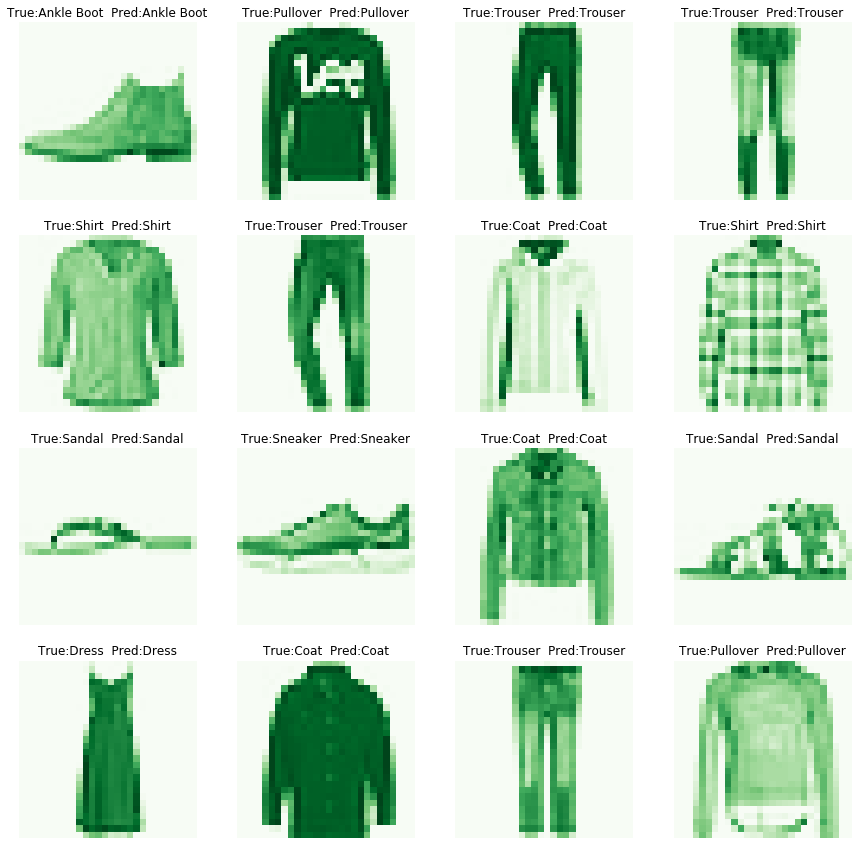

In [75]:
#get the predictions for the test data
predicted_classes = cnn2.predict_classes(testX)
#get the indices to be plotted
y_true = test_data_df.iloc[:, 0]

p = predicted_classes[:10000]
y = y_true[:10000]
correct = np.nonzero(p==y)[0]
incorrect = np.nonzero(p!=y)[0]

def plot_images(data_index,cmap="Blues"):
    # Plot the sample images now
    f, ax = plt.subplots(4,4, figsize=(15,15))

    for i, indx in enumerate(data_index[:16]):
        ax[i//4, i%4].imshow(testX[indx].reshape(ROWS,COLUMNS), cmap=cmap)
        ax[i//4, i%4].axis('off')
        ax[i//4, i%4].set_title("True:{}  Pred:{}".format(labels[y_true[indx]],labels[predicted_classes[indx]]))
    plt.show()    
    
plot_images(correct, "Greens")

#### Incorrectly classified images
Let's see also few images incorrectly classified.

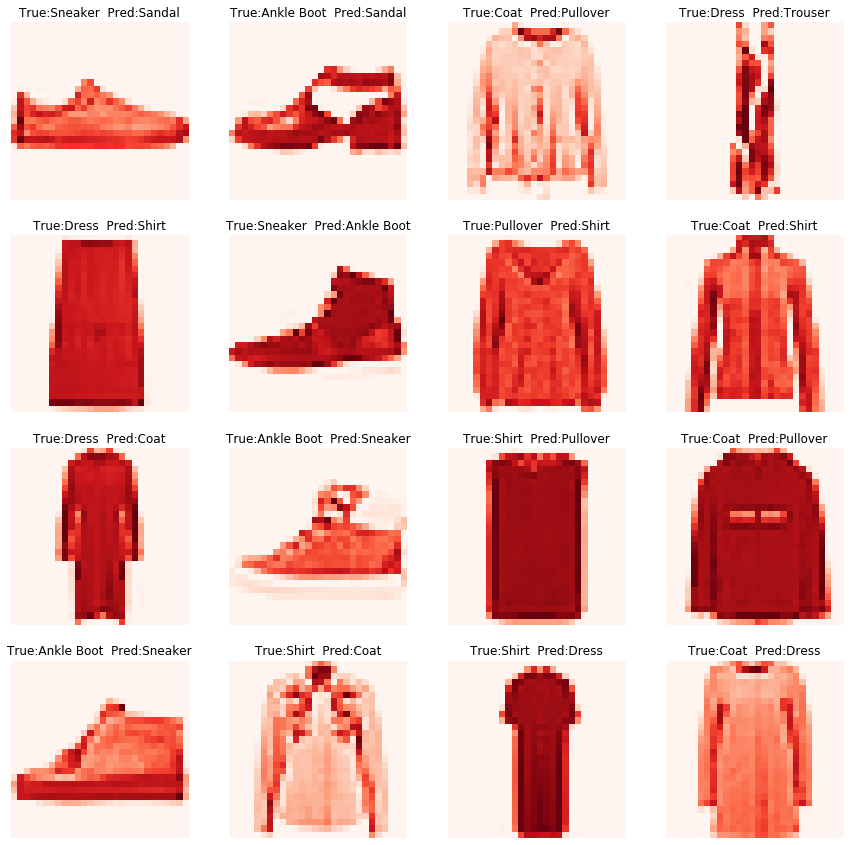

In [76]:
plot_images(incorrect, "Reds")

--------------------------------------------------------------------------------------------------------------

## Other Models


#### Model 1: DNN

As a first model, a Deep Neural Network(DNN) model is discussed. We can successfully train a simple neural network to perform regression and classification. But, a DNN may not perform well with images. Outline of implementation using DNN is depicted in below image. <br>
<img src="https://miro.medium.com/max/1152/1*29kriitcKI6M-wxtkV0NpQ.jpeg" width="50%">



In [80]:
# dnn model
dnn = Sequential()

# Add convolution 2D
dnn.add(Flatten(input_shape=(ROWS, COLUMNS, 1)))
dnn.add(Dense(128, activation='relu'))
dnn.add(Dropout(0.5))
dnn.add(Dense(CLASS, activation='softmax'))
optim = Adam(lr=0.001, decay=0.0) # these are default values in Adam's documentation.

dnn.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])
dnn.build()
dnn.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 128)               100480    
_________________________________________________________________
dropout_13 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


In [81]:
start_time = time.time()
train_model_dnn = dnn.fit(X_train, y_train,
                  batch_size=BATCH_SIZE,
                  epochs=NUMBER_OF_EPOCHS,
                  verbose=1,
                  validation_data=(X_val, y_val))
end_time = time.time()
duration = end_time - start_time

Train on 48000 samples, validate on 12000 samples
Epoch 1/50
48000/48000 [==============================] - 1s 31us/step - loss: 0.7243 - accuracy: 0.7465 - val_loss: 0.4919 - val_accuracy: 0.8319
Epoch 2/50
48000/48000 [==============================] - 1s 27us/step - loss: 0.5087 - accuracy: 0.8214 - val_loss: 0.4279 - val_accuracy: 0.8457
Epoch 3/50
48000/48000 [==============================] - 1s 27us/step - loss: 0.4623 - accuracy: 0.8348 - val_loss: 0.3954 - val_accuracy: 0.8566
Epoch 4/50
48000/48000 [==============================] - 1s 29us/step - loss: 0.4379 - accuracy: 0.8432 - val_loss: 0.3750 - val_accuracy: 0.8663
Epoch 5/50
48000/48000 [==============================] - 1s 27us/step - loss: 0.4163 - accuracy: 0.8512 - val_loss: 0.3677 - val_accuracy: 0.8682
Epoch 6/50
48000/48000 [==============================] - 1s 27us/step - loss: 0.4038 - accuracy: 0.8535 - val_loss: 0.3582 - val_accuracy: 0.8710
Epoch 7/50
48000/48000 [==============================] - 1s 27us/st

In [82]:
score = dnn.evaluate(testX, testY, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print('Duration: ',duration)

10000/10000 [==============================] - 0s 27us/step
Test loss: 0.3482525764107704
Test accuracy: 0.8820000290870667
Duration:  68.71407628059387


#### Model 2: CNN

Convolution layers have proved to be very successful in tasks involving images e.g. image classification, object identification, face recognition etc. They allow parameter sharing which results in a very optimized network compared to using Dense layers.

<img src="https://miro.medium.com/max/1152/1*1YGLNeWWyEsA9NpNK6Y0UA.jpeg" width="50%">

### Increase performance with

#### Learning Rate Decay
If learning rate is too high, model will take unnecessarily big steps on the gradient curve, it could cause jumping over the global optima. In this case reaching global optima takes unnecessarily long.
If learning rate is too small, model might settle in a region (local optima) too early, this also causes the training take longer time.

Decreasing learning rate: When we are finally really close to global optima, if learning rate is not sufficiently small, we might wander around the global optima and never reach it. But if we do learning rate decay, our steps get smaller when approaching global optima; and we can reach it.

Learning rate decay reduces training time, if we set it up wisely.

Results

Did not prevent overfitting.

In [94]:
# cnn3
# Model
cnn3 = Sequential()
# Add convolution 2D
cnn3.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 kernel_initializer='he_normal',
                 input_shape=(ROWS, COLUMNS, 1)))
cnn3.add(MaxPooling2D((2, 2)))
# Add dropouts to the model
cnn3.add(Dropout(0.25))
cnn3.add(Conv2D(64, 
                 kernel_size=(3, 3), 
                 activation='relu'))
cnn3.add(MaxPooling2D(pool_size=(2, 2)))
# Add dropouts to the model
cnn3.add(Dropout(0.25))
cnn3.add(Conv2D(128, (3, 3), activation='relu'))
# Add dropouts to the model
cnn3.add(Dropout(0.4))
cnn3.add(Flatten())
cnn3.add(Dense(128, activation='relu'))
# Add dropouts to the model
cnn3.add(Dropout(0.3))
cnn3.add(Dense(CLASS, activation='softmax'))

optim = Adam(lr=0.002, decay=0.5) # these are default values in Adam's documentation.
cnn3.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=optim,
                  metrics=['accuracy'])
cnn3.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_34 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_34 (Dropout)         (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_35 (Dropout)         (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 3, 3, 128)       

In [95]:
# train model
start_time = time.time()
train_model3 = cnn3.fit(X_train, y_train,
                  batch_size=BATCH_SIZE,
                  epochs=NUMBER_OF_EPOCHS,
                  verbose=1,
                  validation_data=(X_val, y_val))
end_time = time.time()
duration = end_time - start_time

Train on 48000 samples, validate on 12000 samples
Epoch 1/50
48000/48000 [==============================] - 58s 1ms/step - loss: 1.3514 - accuracy: 0.5018 - val_loss: 1.0672 - val_accuracy: 0.6658
Epoch 2/50
48000/48000 [==============================] - 58s 1ms/step - loss: 1.1506 - accuracy: 0.5709 - val_loss: 1.0113 - val_accuracy: 0.6823
Epoch 3/50
48000/48000 [==============================] - 55s 1ms/step - loss: 1.1118 - accuracy: 0.5877 - val_loss: 0.9814 - val_accuracy: 0.6915
Epoch 4/50
48000/48000 [==============================] - 55s 1ms/step - loss: 1.0827 - accuracy: 0.6005 - val_loss: 0.9609 - val_accuracy: 0.6960
Epoch 5/50
48000/48000 [==============================] - 52s 1ms/step - loss: 1.0652 - accuracy: 0.6069 - val_loss: 0.9469 - val_accuracy: 0.7002
Epoch 6/50
48000/48000 [==============================] - 56s 1ms/step - loss: 1.0527 - accuracy: 0.6121 - val_loss: 0.9344 - val_accuracy: 0.7040
Epoch 7/50
48000/48000 [==============================] - 53s 1ms/st

In [96]:
score = dnn.evaluate(testX, testY, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print('Duration: ',duration)

10000/10000 [==============================] - 0s 33us/step
Test loss: 0.3482525764107704
Test accuracy: 0.8820000290870667
Duration:  2444.316346883774


In [97]:
plot_accuracy_and_loss(train_model2)

## Save the Models
Now save the trained models to use them later to test new data.

In [106]:
# Save models
cnn1.save(MODEL_OUTPUT_DIRECTORY+'basic_cnn.h5')
cnn2.save(MODEL_OUTPUT_DIRECTORY+'cnn_with_dropout.h5')
dnn.save(MODEL_OUTPUT_DIRECTORY+'dnn.h5')
cnn3.save(MODEL_OUTPUT_DIRECTORY+'cnn_decay.h5')

# Save models' histories
basin_cnn_df = pd.DataFrame.from_dict(train_model.history)
basin_cnn_df.to_json (MODEL_HISTORY_OUTPUT_DIRECTORY +'basic_cnn_hist.json', orient='records')

cnn_with_dropout_df = pd.DataFrame.from_dict(train_model2.history)
cnn_with_dropout_df.to_json (MODEL_HISTORY_OUTPUT_DIRECTORY +'cnn_with_dropout_hist.json', orient='records')

dnn_df = pd.DataFrame.from_dict(train_model_dnn.history)
dnn_df.to_json (MODEL_HISTORY_OUTPUT_DIRECTORY +'dnn_hist.json', orient='records')

cnn_decay_df = pd.DataFrame.from_dict(train_model3.history)
cnn_decay_df.to_json (MODEL_HISTORY_OUTPUT_DIRECTORY +'cnn_decay_hist.json', orient='records')